https://www.kaggle.com/datasets/dimka11/cl-cup-it-2023-embs

In [2]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=265dfb814e07ce0df46ce137bee6a796350e357bfce2882040a9fae1f8fd6061
  Stored in directory: /root/.cache/pip/wheels/83/71/2b/40d17d21937fed496fb99145227eca8f20b4891240ff60c86f
Successfully built sentence-transformers


In [6]:
import numpy as np
import pandas as pd
import os

from sklearn.metrics import ndcg_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

import umap
from tqdm import tqdm

# from catboost import CatBoostRanker # https://colab.research.google.com/github/catboost/tutorials/blob/master/ranking/ranking_tutorial.ipynb#scrollTo=4pr7PqFuNdYo
# https://www.kaggle.com/code/kooaslansefat/proof-of-concept-catboost-ranker
# https://www.kaggle.com/code/cafelatte1/catboost-ranker-training/notebook

In [7]:
train = pd.read_json('/kaggle/input/cl-cup-it-2023-ds/CL_Cup IT_Data_Scince___VK_/ranking_train.jsonl', lines=True)
test = pd.read_json('/kaggle/input/cl-cup-it-2023-ds/CL_Cup IT_Data_Scince___VK_/ranking_test.jsonl', lines=True)

Look at the examples:

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
train.head(5)

In [ ]:
train.iloc[0, 1][3]['text']

In [ ]:
train.iloc[0, 1][3]['score']

In [ ]:
test.head(5)

In [ ]:
test.loc[0,'comments']

In [ ]:
train.explode('comments').head(20)

In [ ]:
train.explode('comments')['comments'].str['score']

Metric Example

In [10]:
true_relevance = [1, 0, 2]
scores = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]

# Convert to one-hot
values = [1, 0, 2]
n_values = np.max(values) + 1
np.eye(n_values)[values]

y_true = [[0, 1, 0], [1, 0, 0], [0, 0, 1]]
y_score = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
ndcg_score(y_true, y_score, k=2)

## Prepare train & test

In [8]:
def prepare_df(train, test=False):
    train = train.explode('comments')
    if not test:
        train['score'] = train['comments'].str['score']
    train['comment'] = train['comments'].str['text']
    train = train.drop(columns=['comments'])
    train['text_id'] = train.index
    return train
train = prepare_df(train)
scores = train['score'].values
test = prepare_df(test, True)
train.head(20)

,text,score,comment,text_id
0,How many summer Y Combinator fundees decided n...,0,Going back to school is not identical with giv...,0
0,How many summer Y Combinator fundees decided n...,1,There will invariably be those who don't see t...,0
0,How many summer Y Combinator fundees decided n...,2,For me school is a way to be connected to what...,0
0,How many summer Y Combinator fundees decided n...,3,I guess it really depends on how hungry you ar...,0
0,How many summer Y Combinator fundees decided n...,4,I know pollground decided to go back to school...,0
1,CBS acquires last.fm for $280m,0,It will be curious to see where this heads in ...,1
1,CBS acquires last.fm for $280m,1,Does this mean that there's now a big-name com...,1
1,CBS acquires last.fm for $280m,2,Also on BBC News: http://news.bbc.co.uk/1/low...,1
1,CBS acquires last.fm for $280m,3,I don't understand what they do that is worth ...,1
1,CBS acquires last.fm for $280m,4,sold out too cheaply. given their leadership p...,1


## Get Embs from ST

In [15]:
model_name = 'paraphrase-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

In [10]:
get_embs = False

if get_embs:
    batch_size = 256
    train_text_embs = model.encode(train.groupby('text_id').first()['text'].values, batch_size=batch_size)
    test_text_embs = model.encode(test.groupby('text_id').first()['text'].values, batch_size=batch_size)

    train_comment_embs = model.encode(train['comment'].values, batch_size=batch_size)
    test_comment_embs = model.encode(test['comment'].values, batch_size=batch_size)

In [12]:
if get_embs:
    np.save("train_text_embs.npy", train_text_embs)
    np.save("test_text_embs.npy", test_text_embs)
    np.save("train_comment_embs.npy", train_comment_embs)
    np.save("test_comment_embs.npy", test_comment_embs)
else:
    train_text_embs = np.load('/kaggle/input/cl-cup-it-2023-embs/paraphrase-MiniLM-L6-v2/train_text_embs.npy' ,allow_pickle=True)
    test_text_embs = np.load('/kaggle/input/cl-cup-it-2023-embs/paraphrase-MiniLM-L6-v2/test_text_embs.npy' ,allow_pickle=True)
    train_comment_embs = np.load('/kaggle/input/cl-cup-it-2023-embs/paraphrase-MiniLM-L6-v2/train_comment_embs.npy' ,allow_pickle=True)
    test_comment_embs = np.load('/kaggle/input/cl-cup-it-2023-embs/paraphrase-MiniLM-L6-v2/test_comment_embs.npy' ,allow_pickle=True)

## Clusters

https://umap-learn.readthedocs.io/en/latest/basic_usage.html

In [42]:
number_of_examples = 1000

reducer = umap.UMAP(n_neighbors=30,
        min_dist=0.1,
        n_components=2,
        metric='euclidean')

X_embs = StandardScaler().fit_transform(train_comment_embs[0:number_of_examples])
embedding = reducer.fit_transform(X_embs)

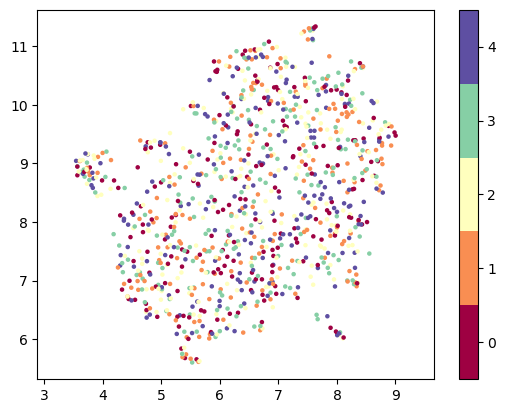

In [43]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=scores[0:number_of_examples], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('', fontsize=24);

## KNN

Split

In [13]:
splitter = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = 9)
split = splitter.split(train_comment_embs, groups=train['text_id'])
train_inds, test_inds = next(split)

X_train = train_comment_embs[train_inds]
X_test = train_comment_embs[test_inds]
y_train = scores[train_inds]
y_test = scores[test_inds]

get part of data for save time

In [14]:
X_train_part = X_train[0:352425//5]
y_train_part = y_train[0:352425//5]

In [15]:
neigh = KNeighborsClassifier(n_neighbors=18, metric='cosine', n_jobs=4)
neigh.fit(X_train_part, y_train_part)

KNeighborsClassifier(metric='cosine', n_jobs=4, n_neighbors=18)

In [16]:
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)
accuracy_score(y_test, y_pred)

0.22361820451708092

ndcg - не уверен, что она правильно тут считается

In [23]:
y_test_ = np.eye(5)[y_test]
ndcg_score(y_test_ ,y_pred_proba)

0.6052703379693775

In [18]:
ndcg = 0
shift = 5

for i in tqdm(range(y_test.shape[0] //5)):
    n_values = 5
    y_test_ = np.eye(n_values)[y_test[i*5:shift]]
    ndcg += ndcg_score(y_test_, y_pred_proba[i*5:shift])
    shift += 5

ndcg = ndcg / (y_test.shape[0] // 5)
print(ndcg)

100%|██████████| 17622/17622 [00:11<00:00, 1494.36it/s]

0.6052703379693739
